<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 -- CNNs, AEs, GANs
https://submitty.cs.rpi.edu/courses/f22/csci4962/course_material/Homeworks/Homework%205.pdf


In [ ]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
# import dataset from kaggle
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d .
clear_output()

In [ ]:
import torchvision
transform = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])
}

# no image augmentation
img_path = 'Vegetable Images'
train_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['test'])
valid_set = torchvision.datasets.ImageFolder(f'{img_path}/validation', transform=transform['test'])
test_set = torchvision.datasets.ImageFolder(f'{img_path}/test', transform=transform['test'])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
sample_batch = next(iter(train_loader))
print('Batch image shape:', sample_batch[0].shape)
print('Batch label shape:', sample_batch[1].shape)
print('Label to id:\n\t', '\n\t'.join([f'{k}({v})' for k,v in train_set.class_to_idx.items()]), sep='')
label_map = {v:k for k,v in train_set.class_to_idx.items()}
num_classes = len(label_map)

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])
Label to id:
	Bean(0)
	Bitter_Gourd(1)
	Bottle_Gourd(2)
	Brinjal(3)
	Broccoli(4)
	Cabbage(5)
	Capsicum(6)
	Carrot(7)
	Cauliflower(8)
	Cucumber(9)
	Papaya(10)
	Potato(11)
	Pumpkin(12)
	Radish(13)
	Tomato(14)


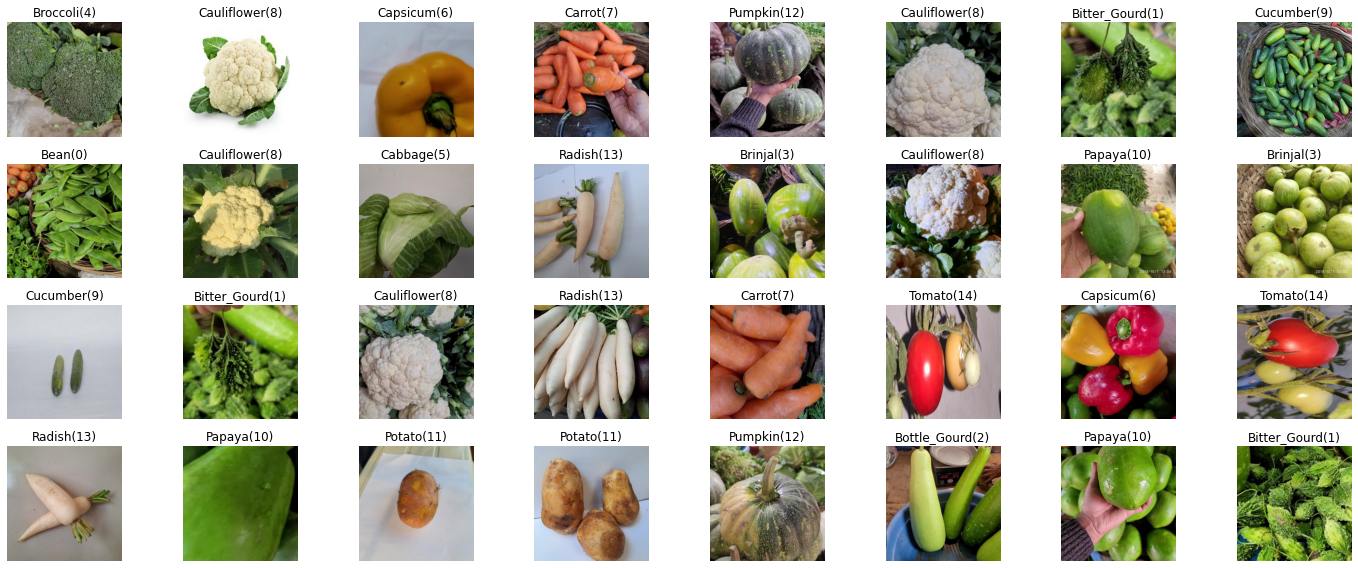

In [ ]:
# Random batch visualization
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# create a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch

sample_count = 32
rows = sample_count // 8
figure, ax = plt.subplots(nrows=rows, ncols=8, figsize=(20, sample_count // rows))

for i, idx in enumerate(range(32)):
    image, label = sample_images[idx], sample_labels[idx]
    image = image / 2 + 0.5
    ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
    title = f'{label_map[sample_labels[idx].item()]}({sample_labels[idx]})'
    ax.ravel()[i].set_title(title)
    ax.ravel()[i].set_axis_off()
    
plt.tight_layout()
plt.show()

### CNN Model Building
For the vegetable image dataset, the images are well separated by shape and color, so we can use conv and maxpool layers to find patterns in small areas on the images.

In [ ]:
from torch import nn
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, device):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Flatten(1),
            nn.LazyLinear(128), 
            nn.GELU(),
            nn.LazyLinear(num_classes)
        )
        self.device = device
        self.to(device)

    def forward(self, image):
        image = torch.tensor(image).to(self.device)
        return self.net(image)

# Define hyperparameters
n_epoch = 10
learning_rate = 1e-4
weight_decay = 3e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNClassifier(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# test a sample batch
logits = model(sample_batch[0])
true_labels = sample_batch[1].long().to(device)
print('Model output shape:', logits.shape)
loss = criterion(logits, true_labels)
print('Make sure loss is scalar:', loss.item())

Model output shape: torch.Size([32, 15])
Make sure loss is scalar: 2.7036283016204834


In [ ]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model(batch[0])
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch[0]).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
        print(f'[ {epoch+1:02d}|{n_epoch} ]', f'avg_train_loss={avg_train_loss}, avg_valid_acc={avg_valid_acc}, ')
    return avg_train_loss_list, avg_valid_acc_list

avg_train_loss_list, avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 01|10 ] avg_train_loss=1.6759672926178872, avg_valid_acc=0.6399601063829787, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 02|10 ] avg_train_loss=0.915584471878975, avg_valid_acc=0.7191932626227115, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 03|10 ] avg_train_loss=0.5666290992167967, avg_valid_acc=0.8407579787234043, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 04|10 ] avg_train_loss=0.3815241704490393, avg_valid_acc=0.8720079787234043, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 05|10 ] avg_train_loss=0.2621222934616146, avg_valid_acc=0.8702349295007422, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 06|10 ] avg_train_loss=0.19340236160927998, avg_valid_acc=0.9004875890752102, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 07|10 ] avg_train_loss=0.14131767218952368, avg_valid_acc=0.8861923763092528, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 08|10 ] avg_train_loss=0.10978192169624351, avg_valid_acc=0.903479610351806, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 09|10 ] avg_train_loss=0.08473000221891698, avg_valid_acc=0.9010416668780307, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 10|10 ] avg_train_loss=0.0688024911024709, avg_valid_acc=0.914450355032657, 


In [ ]:
test_acc_list = []
model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_acc = valid_step(test_batch, model, device)
        test_acc_list.append(test_acc)
print(np.mean(test_acc_list))

  0%|          | 0/94 [00:00<?, ?it/s]

0.9128989361702128


### Report the final evaluation and describe the metrics
The validation accuracy is 91.4% and the test accuracy is 91.3%. The model performs quite well.

In [ ]:
from torchvision import models as M
mobilenet = M.mobilenet_v2(pretrained=True)
mobilenet.out = nn.LazyLinear(num_classes)
mobilenet = mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate, weight_decay=weight_decay)

# test a sample batch
logits = mobilenet.out(mobilenet(sample_batch[0].to(device)))
true_labels = sample_batch[1].long().to(device)
print('Model output shape:', logits.shape)
loss = criterion(logits, true_labels)
print('Make sure loss is scalar:', loss.item())

Model output shape: torch.Size([32, 15])
Make sure loss is scalar: 4.206600189208984


In [ ]:
# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model.out(model(batch[0].to(device)))
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model.out(model(batch[0].to(device))).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
        print('Epoch metrics:', f'avg_train_loss={avg_train_loss}, avg_valid_acc={avg_valid_acc}, ')
    return avg_train_loss_list, avg_valid_acc_list

n_epoch = 5
mn_avg_train_loss_list, mn_avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, mobilenet, criterion, optimizer, device)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.09120548659337879, avg_valid_acc=0.9986702127659575, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.004854156878709333, avg_valid_acc=0.9990026595744681, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.010439171728966976, avg_valid_acc=0.9986702127659575, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.013910622821489313, avg_valid_acc=0.996343085106383, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.02238370281438639, avg_valid_acc=0.9996675531914894, 


In [ ]:
test_acc_list = []
model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_acc = valid_step(test_batch, mobilenet, device)
        test_acc_list.append(test_acc)
print(np.mean(test_acc_list))

  0%|          | 0/94 [00:00<?, ?it/s]

1.0


I used MobileNetV2 as the pretrained model and added a dense layer afterwards. With only a few epochs, the model validation accuracy raises to 99.97%. The MobileNetV2 trained on images that are very similar and much more difficult, so this is one possible reason why this model performs better.

In [ ]:
# with image augmentation
img_path = 'Vegetable Images'
train_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['train'])
valid_set = torchvision.datasets.ImageFolder(f'{img_path}/validation', transform=transform['test'])
test_set = torchvision.datasets.ImageFolder(f'{img_path}/test', transform=transform['test'])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model(batch[0])
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch[0]).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
        print(f'[ {epoch+1:02d}|{n_epoch} ]', f'avg_train_loss={avg_train_loss}, avg_valid_acc={avg_valid_acc}, ')
    return avg_train_loss_list, avg_valid_acc_list

# Define hyperparameters
n_epoch = 10
learning_rate = 1e-4
weight_decay = 3e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNClassifier(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
avg_train_loss_list, avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 01|10 ] avg_train_loss=1.6407724388881024, avg_valid_acc=0.6523714541120732, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 02|10 ] avg_train_loss=0.954755730529838, avg_valid_acc=0.7218528370907966, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 03|10 ] avg_train_loss=0.7233978765351432, avg_valid_acc=0.7617464541120732, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 04|10 ] avg_train_loss=0.5693662960582705, avg_valid_acc=0.8011968085106383, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 05|10 ] avg_train_loss=0.45708707483338396, avg_valid_acc=0.8464095744680851, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 06|10 ] avg_train_loss=0.3776257074336762, avg_valid_acc=0.860261525245423, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 07|10 ] avg_train_loss=0.32019857517374095, avg_valid_acc=0.8413120571603167, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 08|10 ] avg_train_loss=0.27150676874463747, avg_valid_acc=0.8745567380113805, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 09|10 ] avg_train_loss=0.23805402453615468, avg_valid_acc=0.8728945039688273, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[ 10|10 ] avg_train_loss=0.20406386049698666, avg_valid_acc=0.8916223404255319, 


In [ ]:
test_acc_list = []
model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_acc = valid_step(test_batch, model, device)
        test_acc_list.append(test_acc)
print(np.mean(test_acc_list))

  0%|          | 0/94 [00:00<?, ?it/s]

0.9128989361702128


For image augmentation, I used RandomHorizontalFlip and CenterCrop, but they don't seem to perform any better than the unenhanced image. One reason may be CenterCrop that we ignore the outside pixels. Nevertheless, the test accuracy is about the same.